In [1]:
import os
import sys
import tarfile
import numpy as np
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle
from PIL import Image, ImageDraw
from IPython.display import display, Image, HTML
import h5py
import cv2
import random
from scipy.io import loadmat
%matplotlib inline

In [2]:
# define a function for extracting data from gzip files

def extract_tarchive(filename, force=False):
    if (filename.endswith('tar.gz')):
        tar = tarfile.open(filename, 'r:gz')
        tar.extractall()
        tar.close()

In [4]:
# find the tar files

data = [file for file in os.listdir('../RawData') if 'tar.gz' in file]

# change directory to RawData for placement of new directories

os.chdir('../RawData')

# extract the tarchives into new train and test directories

extract_tarchive(data[0])
extract_tarchive(data[1])
extract_tarchive(data[2])

# change directory back to orginal working directory

os.chdir(os.path.pardir)

In [5]:
# convert mat files to HDF5

train = h5py.File('../Computer Vision Capstone/RawData/train/digitStruct.mat')
test = h5py.File('../Computer Vision Capstone/RawData/test/digitStruct.mat')
extra = h5py.File('../Computer Vision Capstone/RawData/extra/digitStruct.mat')

## Explore the data

In [6]:
# the datasets are saved in the HDF5 format which is similar to a dictionary

train['digitStruct'].keys()

<KeysViewHDF5 ['bbox', 'name']>

In [7]:
bbox = train['digitStruct']['bbox']
labels = train['digitStruct']['name']

In [8]:
print(bbox)
print(labels)

<HDF5 dataset "bbox": shape (33402, 1), type "|O">
<HDF5 dataset "name": shape (33402, 1), type "|O">


In [9]:
labels[0]

array([<HDF5 object reference>], dtype=object)

In [10]:
labels[0][0]

<HDF5 object reference>

In [11]:
# retrieve the elements of the names (labels)

train[labels[0][0]][()]

array([[ 49],
       [ 46],
       [112],
       [110],
       [103]], dtype=uint16)

## Create functions for extracting image lables and bounding boxes

In [12]:
# define a function to extract image labels from the labels train and test data

def get_image_label(file, idx):
    img_label = ''.join(map(chr, file[labels[idx][0]][()].flatten()))
    return img_label

In [13]:
# test the get_image_label function

idx=0
get_image_label(train, idx)

'1.png'

In [14]:
# define a function to extract the bounding boxes from the bbox data
# function must separate the data for each of the 5 keys

def get_image_boxes(file, idx):
    bbox_format = ['height', 'left', 'top', 'width', 'label']
    bbox_dict = { key : [] for key in bbox_format}

    box = file[bbox[idx][0]]
    for key in box.keys():
        if box[key].shape[0] == 1:
            bbox_dict[key].append(int(box[key][0][0]))
        else:
            for i in range(box[key].shape[0]):
                bbox_dict[key].append(int(file[box[key][i][0]][()].item()))
    return bbox_dict

In [15]:
# test the get_image_boxes function

idx=0
get_image_boxes(train, idx)

{'height': [219, 219],
 'left': [246, 323],
 'top': [77, 81],
 'width': [81, 96],
 'label': [1, 9]}

In [16]:
# choose random values between 0 and the end of the labels
# use get_image_* functions to extract labels and bounding boxes

len_of_labels = train['digitStruct/name'].shape[0]

for _ in range(5):
    idx = random.randint(0, len_of_labels-1)
    print(get_image_label(train, idx), get_image_boxes(train, idx))

12293.png {'height': [35, 35], 'left': [30, 51], 'top': [5, 3], 'width': [21, 20], 'label': [2, 10]}
21796.png {'height': [119, 119, 119], 'left': [108, 161, 204], 'top': [15, 5, 12], 'width': [46, 39, 50], 'label': [1, 2, 1]}
25844.png {'height': [26, 26], 'left': [27, 38], 'top': [4, 4], 'width': [10, 10], 'label': [3, 7]}
11852.png {'height': [38, 38], 'left': [40, 59], 'top': [1, 3], 'width': [20, 32], 'label': [4, 6]}
10239.png {'height': [24], 'left': [43], 'top': [18], 'width': [11], 'label': [3]}


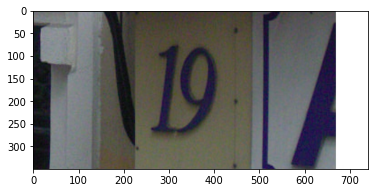

In [17]:
# display an image

img = 'RawData/train/1.png'
image = mpimg.imread(img)
plt.imshow(image)
plt.show()

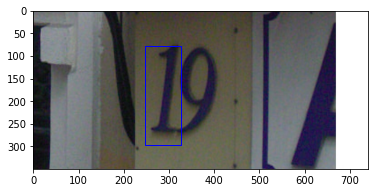

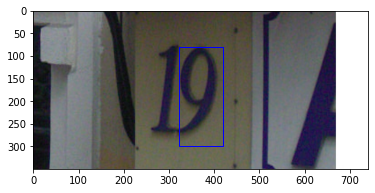

In [18]:
# use the get_image_boxes function to produce images with bounding boxes

box = get_image_boxes(train, 0)
img = 'RawData/train/1.png'

for i in range(len(box['top'])):
    fig, ax = plt.subplots(1)
    image = mpimg.imread(img)
    ax.imshow(image)
    ax.add_patch(Rectangle((box['left'][i], box['top'][i]),
                      box['width'][i], box['height'][i],
                      linewidth=1, edgecolor='b', facecolor='none'))
    plt.show()

In [19]:
# define a function for displaying the images with bounding boxes

def show_bboxes(img, file, idx):
    data = get_image_boxes(file, idx)
    fig, ax = plt.subplots()
    image = mpimg.imread(img) 
    for i in range(len(data['top'])):   
        ax.add_patch(Rectangle((data['left'][i], data['top'][i]), data['width'][i], data['height'][i],
                           linewidth=1, edgecolor='b', facecolor='none'))
    image = ax.imshow(image)
    return image

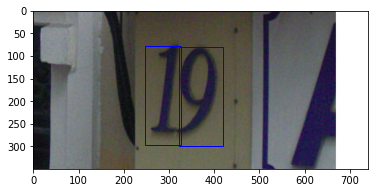

In [20]:
img = 'RawData/train/1.png'
file = train
idx=0

show_bboxes(img, file, idx)

## Define functions for processing the data to csv

In [21]:
# define a function to 

def dict_to_df(file):
    box_list = []
    data_length = file['digitStruct/name'].shape[0]
    idx = 0
    while idx in range(data_length):
        fn = get_image_label(file, idx)
        bbox = get_image_boxes(file, idx)
        box_list.append({'filename': fn,
                          'label': bbox['label'],
                          'width': bbox['width'],
                          'height': bbox['height'],
                          'top': bbox['top'],
                          'left': bbox['left']})
        idx+=1
    return pd.DataFrame(box_list)

In [23]:
train_df = dict_to_df(train)
test_df = dict_to_df(test)
extra_df = dict_to_df(extra)

In [ ]:
# define paths for the data

path = os.getcwd()
train_path = os.path.join(path, 'RawData/train')
test_path = os.path.join(path, 'RawData/test')